In [1]:
# Carregando pacotes
import numpy as np # Arrays e funções matemáticas.
import pandas as pd # Manipulação de data frames.
#from pandas_profiling import ProfileReport # Relatório EDA
import matplotlib.pyplot as plt # Gráficos.
import seaborn as sns # Gráficos.
import scipy.stats as stats # Funções estatísticas.
import random # Random Seed
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, roc_auc_score ,roc_curve, matthews_corrcoef, f1_score , precision_recall_curve
import shap

random.seed(42) # Garantir reprodutibilidade.
warnings.filterwarnings("ignore")

--- 

### 1. Entendimento do problema de negócio
Prever o comportamento para reter clientes.   
Analisar todos os dados relevantes do cliente e desenvolver programas focados na retenção de clientes.

<img src="churn.jpeg" width="600">

--- 

### 2. Entendimento dos Dados

**Content**
Cada linha representa um cliente, cada coluna contém os atributos do cliente.


Clientes que saíram no último mês - a coluna é chamada de Churn.


Serviços que cada cliente assinou - telefone, várias linhas, internet, segurança online, backup online, proteção de dispositivo, suporte técnico e streaming de TV e filmes.


Informações da conta do cliente - há quanto tempo ele é cliente, contrato, forma de pagamento, faturamento sem papel, cobranças mensais e cobranças totais.  

Informações demográficas sobre clientes - sexo, faixa etária e se eles têm parceiros e dependentes

**customerID**: Customer ID
    
**gender**: Se o cliente é homem ou mulher

**SeniorCitizen**: Se o cliente é idoso ou não (1, 0)

**Partner**: Se o cliente tem um parceiro ou não (Yes, No)

**Dependents**: Se o cliente tem dependentes ou não (Yes, No)

**tenure**: Número de meses que o cliente permaneceu na empresa

**PhoneService**: Se o cliente tem um serviço de telefone ou não (Yes, No)

**MultipleLines**: Se o cliente tem várias linhas ou não (Yes, No, No phone service)

**InternetService**: Provedor de serviços de Internet do cliente (DSL, Fiber optic, No)

**OnlineSecurity**: Se o cliente tem segurança online ou não (Yes, No, No internet service)

**OnlineBackup**: Se o cliente tem backup online ou não (Yes, No, No internet service)

**DeviceProtection**: Se o cliente tem proteção de dispositivo ou não (Yes, No, No internet service)

**TechSupport**: Se o cliente tem suporte técnico ou não (Yes, No, No internet service)

**StreamingTV**: Se o cliente tem streaming de TV ou não (Yes, No, No internet service)

**StreamingMovies**: Se o cliente tem streaming de filmes ou não (Yes, No, No internet service)

**Contract**: O termo do contrato do cliente (Month-to-month, One year, Two year)

**PaperlessBilling**: Se o cliente tem faturamento sem papel ou não (Yes, No)

**PaymentMethod**: O método de pagamento do cliente (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))

**MonthlyCharges**: O valor cobrado do cliente mensalmente

**TotalCharges**: O valor total cobrado do cliente

**Churn**: Se o cliente mudou de operadora ( churn ) ou não (Yes or No)                                                        

In [2]:
# Carregando os dados
telecom = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
telecom.columns = [c.lower().replace(' ', '_').replace('?', '').replace("'", "") for c in telecom.columns] 

In [4]:
telecom.head(2)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [5]:
# Quantas transações são churn, percentualmente?
telecom['churn'].value_counts()/len(telecom) * 100

No     73.463013
Yes    26.536987
Name: churn, dtype: float64

In [6]:
# profile = ProfileReport(telecom)
# profile.to_file("eda.html")

In [7]:
telecom['totalcharges'] = telecom['totalcharges'].replace(' ', np.nan)
telecom['totalcharges'] = pd.to_numeric(telecom['totalcharges'])

In [8]:
value = (telecom['totalcharges']/telecom['totalcharges']).median()*telecom['totalcharges']
telecom['totalcharges'] = value.where(telecom['totalcharges'] == np.nan, other = telecom['totalcharges'])

**Churn (Target Variable)**

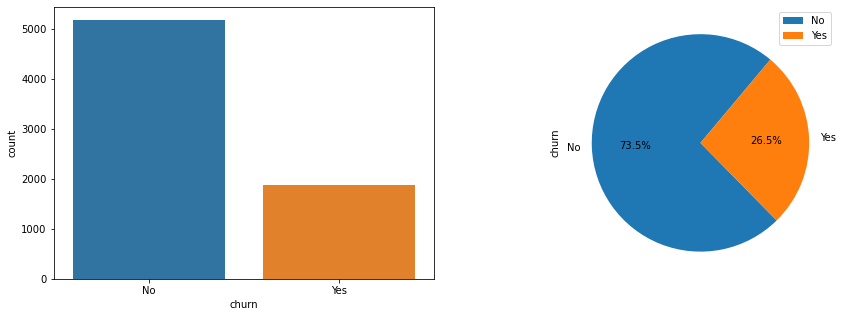

In [9]:
fig, axs = plt.subplots(1,2, figsize = (15,5))
plt1 = sns.countplot(telecom['churn'], ax = axs[0])
pie_churn = pd.DataFrame(telecom['churn'].value_counts())
pie_churn.plot.pie( subplots=True,labels = pie_churn.index.values, autopct='%1.1f%%', figsize = (15,5), startangle= 50, ax = axs[1])
plt.gca().set_aspect('equal')
plt.show()

**Tenure - The time for which a customer has been using the service.**

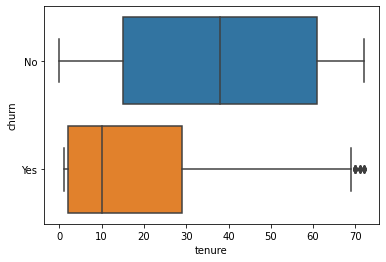

In [10]:
sns.boxplot(x = 'tenure', y = 'churn', data = telecom)
plt.show()

> O cliente com mais estabilidade tende a mudar menos.

**Phone Service -  Whether a customer has a landline phone service along with the internet service.**

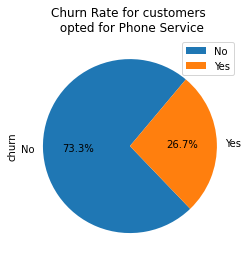

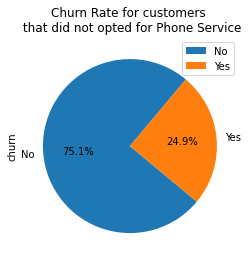

In [11]:
pie_PhoneService_Yes = pd.DataFrame(telecom[telecom['phoneservice'] == "Yes"]['churn'].value_counts())
pie_PhoneService_Yes.plot.pie(subplots=True, labels = pie_PhoneService_Yes.index.values, autopct='%1.1f%%', startangle= 50 )
plt.title('Churn Rate for customers \n opted for Phone Service')
plt.gca().set_aspect('equal')

pie_PhoneService_No = pd.DataFrame(telecom[telecom['phoneservice'] == "No"]['churn'].value_counts())
pie_PhoneService_No.plot.pie(subplots=True, labels = pie_PhoneService_Yes.index.values, autopct='%1.1f%%', startangle= 50)
plt.title('Churn Rate for customers \n that did not opted for Phone Service')
plt.gca().set_aspect('equal')

plt.show() 

> A opção pelo serviço telefônico não tem impacto significativo na taxa de desligamento.

**Contract**

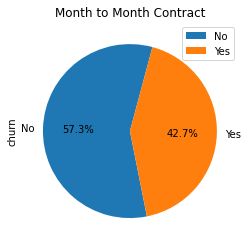

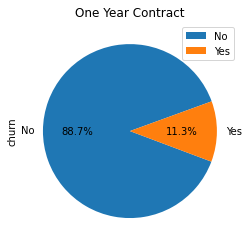

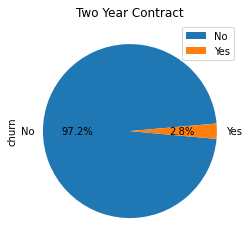

In [12]:
pie_Contract_m2m = pd.DataFrame(telecom[telecom['contract'] == "Month-to-month"]['churn'].value_counts())
pie_Contract_m2m.plot.pie(subplots=True, labels = pie_Contract_m2m.index.values, autopct='%1.1f%%', startangle= 75)
plt.title('Month to Month Contract')
plt.gca().set_aspect('equal')

pie_Contract_1y = pd.DataFrame(telecom[telecom['contract'] == "One year"]['churn'].value_counts())
pie_Contract_1y.plot.pie(subplots=True, labels = pie_Contract_1y.index.values, autopct='%1.1f%%', startangle= 20)
plt.title('One Year Contract')
plt.gca().set_aspect('equal')

pie_Contract_2y = pd.DataFrame(telecom[telecom['contract'] == "Two year"]['churn'].value_counts())
pie_Contract_2y.plot.pie(subplots=True, labels = pie_Contract_2y.index.values, autopct='%1.1f%%', startangle= 5)
plt.title('Two Year Contract')
plt.gca().set_aspect('equal')

plt.show()

> Clientes com contratos de um e dois anos tendem a ter um churn muito menor do que o contrato mensal.

**Paperless Billing**

<Figure size 1080x360 with 0 Axes>

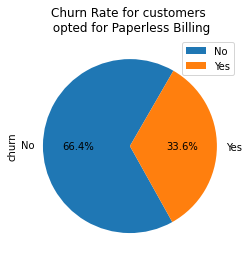

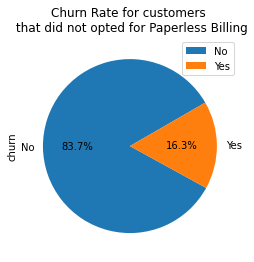

In [13]:
plt.figure(figsize=(15,5))

pie_PaperlessBilling_Yes = pd.DataFrame(telecom[telecom['paperlessbilling'] == "Yes"]['churn'].value_counts())
pie_PaperlessBilling_Yes.plot.pie(subplots=True, labels = pie_PaperlessBilling_Yes.index.values, autopct='%1.1f%%', startangle= 60)
plt.title('Churn Rate for customers \n opted for Paperless Billing')
plt.gca().set_aspect('equal')


pie_PaperlessBilling_No = pd.DataFrame(telecom[telecom['paperlessbilling'] == "No"]['churn'].value_counts())
pie_PaperlessBilling_No.plot.pie(subplots=True, labels = pie_PaperlessBilling_No.index.values, autopct='%1.1f%%', startangle= 30)
plt.title('Churn Rate for customers \n that did not opted for Paperless Billing')
plt.gca().set_aspect('equal')

plt.show()

> Clientes com que pagam a fatura digita tendem a ter um churn maior.

--- 

### 3. Preparação dos dados

Converting some binary variables (Yes/No) to 0/1

In [14]:
# List of variables to map
varlist =  ['phoneservice', 'paperlessbilling', 'churn', 'partner', 'dependents']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the housing list
telecom[varlist] = telecom[varlist].apply(binary_map)

In [15]:
telecom.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,No,...,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,Yes,...,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,Yes,...,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,0,0,2,1,No,Fiber optic,No,...,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


* For categorical variables with multiple levels, create dummy features (one-hot encoded)

In [16]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy1 = pd.get_dummies(telecom[['contract', 'paymentmethod', 'gender', 'internetservice']], drop_first=True)

# Adding the results to the master dataframe
telecom = pd.concat([telecom, dummy1], axis=1)

In [17]:
telecom.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,totalcharges,churn,contract_One year,contract_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,gender_Male,internetservice_Fiber optic,internetservice_No
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,No,...,29.85,0,0,0,0,1,0,0,0,0
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,Yes,...,1889.50,0,1,0,0,0,1,1,0,0
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,Yes,...,108.15,1,0,0,0,0,1,1,0,0
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,Yes,...,1840.75,0,1,0,0,0,0,1,0,0
4,9237-HQITU,Female,0,0,0,2,1,No,Fiber optic,No,...,151.65,1,0,0,0,1,0,0,1,0


In [18]:
# Creating dummy variables for the remaining categorical variables and dropping the level with big names.

# Creating dummy variables for the variable 'MultipleLines'
ml = pd.get_dummies(telecom['multiplelines'], prefix='multiplelines')
# Dropping MultipleLines_No phone service column
ml1 = ml.drop(['multiplelines_No phone service'], 1)
#Adding the results to the master dataframe
telecom = pd.concat([telecom,ml1], axis=1)

# Creating dummy variables for the variable 'OnlineSecurity'.
os = pd.get_dummies(telecom['onlinesecurity'], prefix='onlinesecurity')
os1 = os.drop(['onlinesecurity_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,os1], axis=1)

# Creating dummy variables for the variable 'OnlineBackup'.
ob = pd.get_dummies(telecom['onlinebackup'], prefix='onlinebackup')
ob1 = ob.drop(['onlinebackup_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,ob1], axis=1)

# Creating dummy variables for the variable 'DeviceProtection'. 
dp = pd.get_dummies(telecom['deviceprotection'], prefix='deviceprotection')
dp1 = dp.drop(['deviceprotection_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,dp1], axis=1)

# Creating dummy variables for the variable 'TechSupport'. 
ts = pd.get_dummies(telecom['techsupport'], prefix='techsupport')
ts1 = ts.drop(['techsupport_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,ts1], axis=1)

# Creating dummy variables for the variable 'StreamingTV'.
st =pd.get_dummies(telecom['streamingtv'], prefix='streamingtv')
st1 = st.drop(['streamingtv_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,st1], axis=1)

# Creating dummy variables for the variable 'StreamingMovies'. 
sm = pd.get_dummies(telecom['streamingmovies'], prefix='streamingmovies')
sm1 = sm.drop(['streamingmovies_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,sm1], axis=1)

In [19]:
telecom.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,onlinebackup_No,onlinebackup_Yes,deviceprotection_No,deviceprotection_Yes,techsupport_No,techsupport_Yes,streamingtv_No,streamingtv_Yes,streamingmovies_No,streamingmovies_Yes
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,No,...,0,1,1,0,1,0,1,0,1,0
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,Yes,...,1,0,0,1,1,0,1,0,1,0
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,Yes,...,0,1,1,0,1,0,1,0,1,0
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,Yes,...,1,0,0,1,0,1,1,0,1,0
4,9237-HQITU,Female,0,0,0,2,1,No,Fiber optic,No,...,1,0,1,0,1,0,1,0,1,0


* Dropping the repeated variables

In [20]:
# We have created dummies for the below variables, so we can drop them
telecom = telecom.drop(['contract','paymentmethod','gender','multiplelines','internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection','techsupport', 'streamingtv', 'streamingmovies'], 1)

In [21]:
telecom.head()

,customerid,seniorcitizen,partner,dependents,tenure,phoneservice,paperlessbilling,monthlycharges,totalcharges,churn,...,onlinebackup_No,onlinebackup_Yes,deviceprotection_No,deviceprotection_Yes,techsupport_No,techsupport_Yes,streamingtv_No,streamingtv_Yes,streamingmovies_No,streamingmovies_Yes
0,7590-VHVEG,0,1,0,1,0,1,29.85,29.85,0,...,0,1,1,0,1,0,1,0,1,0
1,5575-GNVDE,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,1,1,0,1,0,1,0
2,3668-QPYBK,0,0,0,2,1,1,53.85,108.15,1,...,0,1,1,0,1,0,1,0,1,0
3,7795-CFOCW,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,1,0,1,1,0,1,0
4,9237-HQITU,0,0,0,2,1,1,70.70,151.65,1,...,1,0,1,0,1,0,1,0,1,0


* Checking for Outliers

In [22]:
# Checking for outliers in the continuous variables
num_telecom = telecom[['tenure','monthlycharges','seniorcitizen','totalcharges']]
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
num_telecom.describe(percentiles=[.25, .5, .75, .90, .95, .99])

,tenure,monthlycharges,seniorcitizen,totalcharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,0.162147,2283.300441
std,24.559481,30.090047,0.368612,2266.771362
min,0.000000,18.250000,0.000000,18.800000
25%,9.000000,35.500000,0.000000,401.450000
50%,29.000000,70.350000,0.000000,1397.475000
75%,55.000000,89.850000,0.000000,3794.737500
90%,69.000000,102.600000,1.000000,5976.640000
95%,72.000000,107.400000,1.000000,6923.590000
99%,72.000000,114.729000,1.000000,8039.883000


* Checking for Missing Values and Inputing Them

In [23]:
# Adding up the missing values (column-wise)
telecom.isnull().sum()

customerid                                0
seniorcitizen                             0
partner                                   0
dependents                                0
tenure                                    0
phoneservice                              0
paperlessbilling                          0
monthlycharges                            0
totalcharges                             11
churn                                     0
contract_One year                         0
contract_Two year                         0
paymentmethod_Credit card (automatic)     0
paymentmethod_Electronic check            0
paymentmethod_Mailed check                0
gender_Male                               0
internetservice_Fiber optic               0
internetservice_No                        0
multiplelines_No                          0
multiplelines_Yes                         0
onlinesecurity_No                         0
onlinesecurity_Yes                        0
onlinebackup_No                 

In [24]:
#It means that 11/7043 = 0.001561834 i.e 0.1%, best is to remove these observations from the analysis

In [25]:
# Checking the percentage of missing values
round(100*(telecom.isnull().sum()/len(telecom.index)), 2)

customerid                               0.00
seniorcitizen                            0.00
partner                                  0.00
dependents                               0.00
tenure                                   0.00
phoneservice                             0.00
paperlessbilling                         0.00
monthlycharges                           0.00
totalcharges                             0.16
churn                                    0.00
contract_One year                        0.00
contract_Two year                        0.00
paymentmethod_Credit card (automatic)    0.00
paymentmethod_Electronic check           0.00
paymentmethod_Mailed check               0.00
gender_Male                              0.00
internetservice_Fiber optic              0.00
internetservice_No                       0.00
multiplelines_No                         0.00
multiplelines_Yes                        0.00
onlinesecurity_No                        0.00
onlinesecurity_Yes                

In [26]:
# Removing NaN TotalCharges rows
telecom = telecom[~np.isnan(telecom['totalcharges'])]

--- 

### 4. Modelagem

<img src="random-forest.png" width="400">

In [51]:
# Putting feature variable to X
X = telecom.drop(['churn','customerid'], axis=1)

X.head()

,seniorcitizen,partner,dependents,tenure,phoneservice,paperlessbilling,monthlycharges,totalcharges,contract_One year,contract_Two year,...,onlinebackup_No,onlinebackup_Yes,deviceprotection_No,deviceprotection_Yes,techsupport_No,techsupport_Yes,streamingtv_No,streamingtv_Yes,streamingmovies_No,streamingmovies_Yes
0,0,1,0,1,0,1,29.85,29.85,0,0,...,0,1,1,0,1,0,1,0,1,0
1,0,0,0,34,1,0,56.95,1889.50,1,0,...,1,0,0,1,1,0,1,0,1,0
2,0,0,0,2,1,1,53.85,108.15,0,0,...,0,1,1,0,1,0,1,0,1,0
3,0,0,0,45,0,0,42.30,1840.75,1,0,...,1,0,0,1,0,1,1,0,1,0
4,0,0,0,2,1,1,70.70,151.65,0,0,...,1,0,1,0,1,0,1,0,1,0


In [28]:
# Putting response variable to y
y = telecom['churn']

y.head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int64

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

#### FEATURE SCALING

A escala de features envolve a modificação de valores por um dos dois métodos principais: Normalização ou Padronização.  
A normalização pega os valores de entrada e os modifica para ficar entre 0 e 1.   
Os métodos de padronização modificam os valores para que eles centralizem em 0 e tenham um desvio padrão de 1.

In [54]:
scaler = StandardScaler()

X_train[['tenure','monthlycharges','totalcharges']] = scaler.fit_transform(X_train[['tenure','monthlycharges','totalcharges']])

X_train.head()

,seniorcitizen,partner,dependents,tenure,phoneservice,paperlessbilling,monthlycharges,totalcharges,contract_One year,contract_Two year,...,gender_Male,internetservice_Fiber optic,internetservice_No,multiplelines_Yes,onlinesecurity_Yes,onlinebackup_Yes,deviceprotection_Yes,techsupport_Yes,streamingtv_Yes,streamingmovies_Yes
879,0,0,0,0.019693,1,1,-0.338074,-0.276449,0,0,...,1,0,0,1,0,1,0,0,0,0
5790,0,1,1,0.305384,0,1,-0.464443,-0.112702,0,0,...,0,0,0,0,0,1,0,0,1,1
6498,0,0,0,-1.286319,1,1,0.581425,-0.974430,0,0,...,0,1,0,0,0,1,1,0,0,0
880,0,0,0,-0.919003,1,1,1.505913,-0.550676,0,0,...,1,1,0,0,1,1,1,1,1,1
2784,0,0,1,-1.163880,1,1,1.106854,-0.835971,0,0,...,0,1,0,0,0,0,1,1,1,1


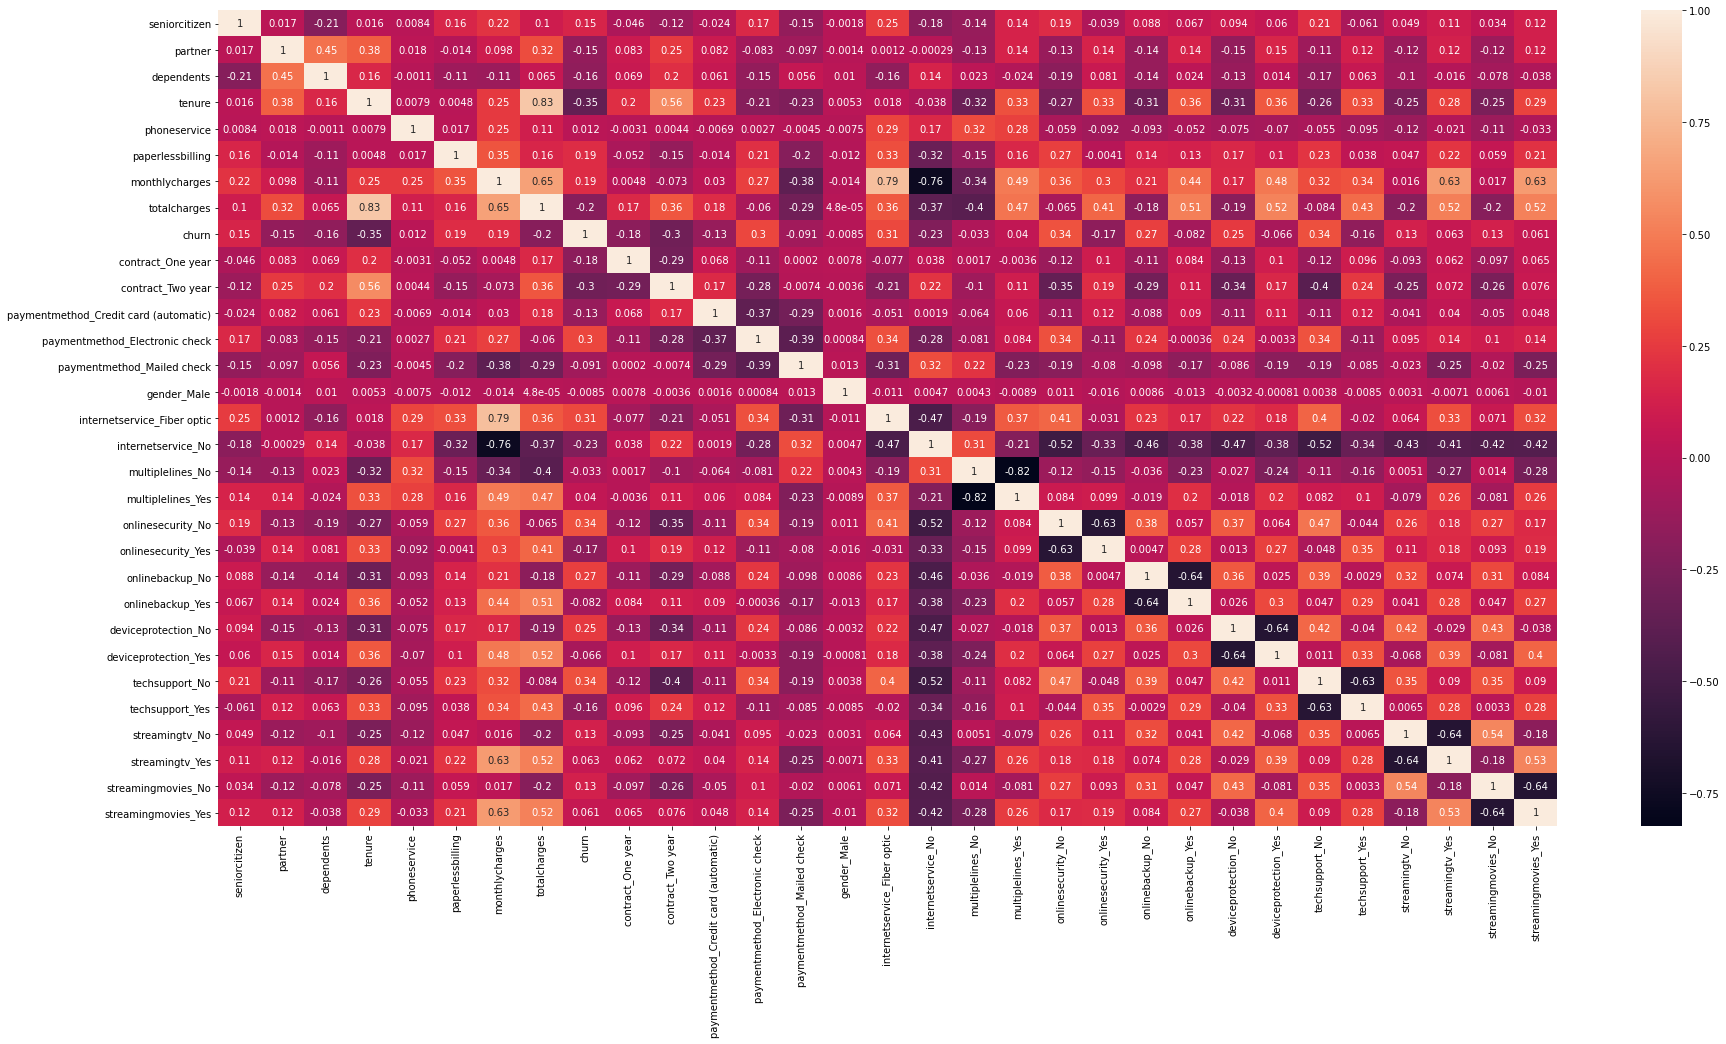

In [31]:
# Let's see the correlation matrix 
plt.figure(figsize = (30,15))        # Size of the figure
sns.heatmap(telecom.corr(),annot = True)
plt.show()

* Dropping highly correlated dummy variables

In [32]:
X_test = X_test.drop(['multiplelines_No','onlinesecurity_No','onlinebackup_No','deviceprotection_No','techsupport_No','streamingtv_No','streamingmovies_No'], 1)

X_train = X_train.drop(['multiplelines_No','onlinesecurity_No','onlinebackup_No','deviceprotection_No','techsupport_No','streamingtv_No','streamingmovies_No'], 1)

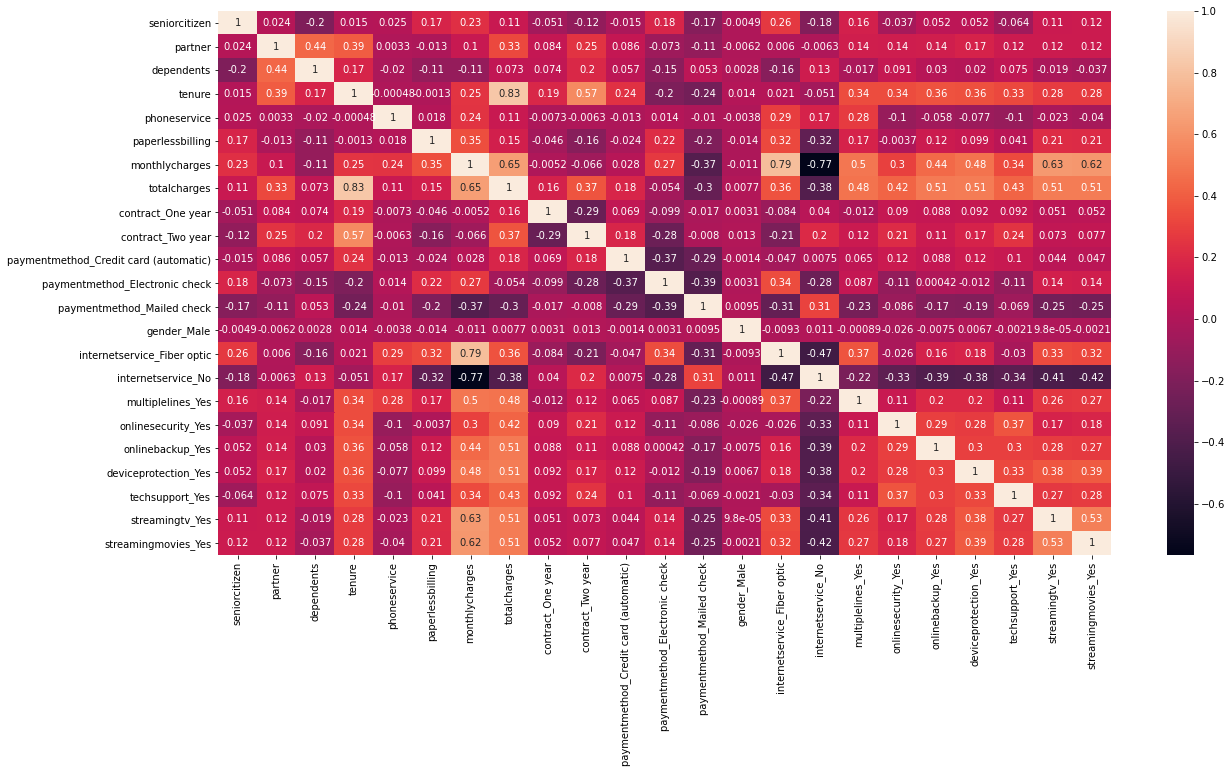

In [33]:
#Checking the Correlation Matrix
#After dropping highly correlated variables now let's check the correlation matrix again.

plt.figure(figsize = (20,10))
sns.heatmap(X_train.corr(),annot = True)
plt.show()

In [34]:
clf =  RandomForestClassifier()
clf.fit(X_train, y_train) 

RandomForestClassifier()

In [35]:
X_test[['tenure','monthlycharges','totalcharges']] = scaler.transform(X_test[['tenure','monthlycharges','totalcharges']])

In [36]:
predictions = clf.predict_proba(X_test)

In [37]:
y_pred = predictions[:,1] > 0.5 # Mudança do threshold.

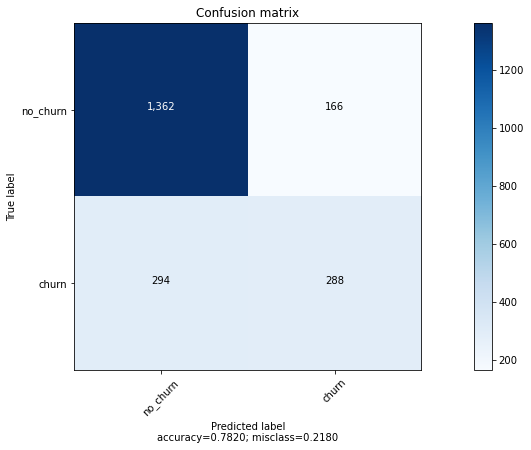

In [38]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


cm = confusion_matrix(y_test, y_pred)
    
plot_confusion_matrix(cm,
                          ['no_churn','churn'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

<img src="metricas_classificacao.png" width="500">

**Acurácia**: indica uma performance geral do modelo. Dentre todas as classificações, quantas o modelo classificou corretamente;   
A acurácia é uma boa indicação geral de como o modelo performou. 
Porém, pode haver situações em que ela é enganosa.   
Por exemplo, na criação de um modelo de identificação de fraudes em cartões de crédito, o número de casos considerados como fraude pode ser bem pequeno
em relação ao número de casos considerados legais.   
Para colocar em números, em uma situação hipotética de 280000 casos legais e 2000 casos fraudulentos, 
um modelo simplório que simplesmente classifica tudo como legal obteria uma acurácia de 99,3%. Ou seja, você estaria validando como ótimo um modelo que 
falha em detectar fraudes.

**Precisão**: dentre todas as classificações de classe Positivo que o modelo fez, quantas estão corretas;  
A precisão pode ser usada em uma situação em que os Falsos Positivos são considerados mais prejudiciais que os Falsos Negativos.
Por exemplo, ao classificar uma ação como um bom investimento, é necessário que o modelo esteja correto, mesmo que acabe classificando
bons investimentos como maus investimentos (situação de Falso Negativo) no processo.   
Ou seja, o modelo deve ser preciso em suas classificações, pois a partir do momento que consideramos um investimento bom quando na verdade ele não é, 
uma grande perda de dinheiro pode acontecer.

**Recall/Revocação/Sensibilidade**: dentre todas as situações de classe Positivo como valor esperado, quantas estão corretas; 
O recall pode ser usada em uma situação em que os Falsos Negativos são considerados mais prejudiciais que os Falsos Positivos. Por exemplo, o modelo deve de qualquer maneira encontrar todos os pacientes doentes, mesmo que classifique alguns saudáveis como doentes (situação de Falso Positivo) no processo. Ou seja, o modelo deve ter alto recall, pois classificar pacientes doentes como saudáveis pode ser uma tragédia.

**F1-Score**: média harmônica entre precisão e recall. 
O F1-Score é simplesmente uma maneira de observar somente 1 métrica ao invés de duas (precisão e recall) em alguma situação.
É uma média harmônica entre as duas, que está muito mais próxima dos menores valores do que uma média aritmética simples. 
Ou seja, quando tem-se um F1-Score baixo, é um indicativo de que ou a precisão ou o recall está baixo.

In [39]:
target_names = ['no_churn', 'churn']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    no_churn       0.82      0.89      0.86      1528
       churn       0.63      0.49      0.56       582

    accuracy                           0.78      2110
   macro avg       0.73      0.69      0.71      2110
weighted avg       0.77      0.78      0.77      2110



In [42]:
f1_score(y_test, y_pred)

0.5559845559845561

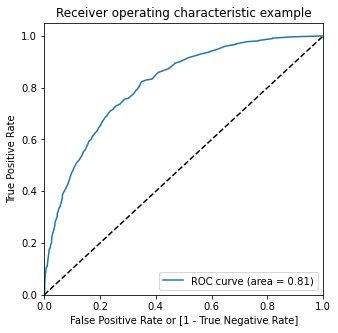

In [55]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])

draw_roc(y_test, predictions[:,1])

--- 

### REFERÊNCIAS

https://www.kaggle.com/blastchar/telco-customer-churn